# Proyecto 02: Clasificación Supervisada

---

### Integrantes:
- Kalos Lazo
- Benjamín Soto
- Lucas Carranza
- José Osnayo

---

### Importar librerías escenciales

A continuación se importarán las librerías escenciales para proceder con nuestro análisis exploratorio de datos (EDA), los archivos utilizan el formato `.h5` destinado para trabajar con archivos complejos, se procederá a utilizar la librería `h5py`.

In [78]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import h5py

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

---

### Data

Considerando que dentro de nuestra estructura contamos con una carpeta de datos en la localización raíz `/data`, importamos los archivos train y test para entrenamiento y testeo respectivamente.

Se procede a crear una [función](https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python) para convertir de nuestros archivos de `.h5` a un pandas dataframe, de tal forma que podamos utilizar nuestros datos al aplicar el modelo. La función toma la ubicación del archivo y convierte cada dataset en un elemento del tipo numpy array, posteriormente se instancia como un objeto pandas dataframe.

Por último una vez tenemos un diccionario de dataframes, se hace esto para mantener el nombre de cada dataset para un posterior análisis y correctitud. Esto se logra al ver que al sacar las features y juntar todas las características necesitamos un mecanismo que diferencie entre las columnas.

In [92]:
def file_data_processing(path):
    with h5py.File(path, 'r') as hf:
        return {each_dataset: pd.DataFrame(hf[each_dataset][()]) for each_dataset in hf}

path = './data/'
train_path = f'{path}/train.h5'
test_path = f'{path}/test.h5'
train_data = file_data_processing(train_path)

print("Claves de columnas en train_data\n:", train_data.keys())

Claves de columnas en train_data
: dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y'])


---

### Extracción de características

Hasta ahora contamos con una matriz de matrices, donde en cada uno de sus hijos interiores representa un dataset del usuario para una respectiva acción con sus EEG, por ejemplo el de caminar hacia arriba, caminar hacia abajo, entre otras.

Al tener 128 características por lo que debemos inicialmente reducir la dimensionalidad, utilizaremos la reducción por LDA (Linear Discriminant Analysis), una vez logramos esto individualmente, procedemos a juntarlos todos en una matriz. Si no hicieramos esta reducción trabajaríamos con una matriz de $128 \cdot 9 = 1152$ características. 

In [95]:
def dataset_descriptive_features(df, dataset_name):
    df_conversion_long = df.copy();
    df_conversion_long['id'] = df.index;
    df_conversion_long = df_conversion_long.melt(id_vars=['id'], var_name='time', value_name='value')
    
    extracted_features = extract_features(df_conversion_long, column_id = 'id', column_sort = 'time',  default_fc_parameters = MinimalFCParameters(), n_jobs=4)
    extracted_features.columns = [f"{dataset_name}_{each_col}" for each_col in extracted_features.columns]
    
    return extracted_features

def get_datasets_features(train_data):
    features_list = [];
    for name, df in train_data.items():
        if name != 'y':
            extracted_features = dataset_descriptive_features(df, name)
            print(f"Dimension de características extraídas en {name}: {extracted_features.shape}")
            features_list.append(extracted_features)
    return features_list;

x_train_features = get_datasets_features(train_data);

KeyError: "The following 'id_vars' are not present in the DataFrame: ['id']"

Con la función anterior, `descriptive_features`, se logra obtener las características más importantes y descriptivas de cada dataset. Podríamos hacerlo manual obteniendo mediana, mínimo, máximo, entre otros, pero para este caso ya utilizamos funcionalidad hecha por la librería de [TsFresh](https://tsfresh.readthedocs.io/en/latest/): extrae automáticamente [características importantes](https://www.linkedin.com/pulse/unlocking-time-series-insights-tsfresh-python-guide-rany-5yr7c/) acerca de una serie temporal.

Para aplicar este método primero debe convertirse el dataframe a un formato largo (long) que es exigido por la librería, se basa en una matriz tal que cada fila es una observación y cada columna un momento del tiempo, posteriormente ese train data sera dividido para el eje X, Y. El resultado esperado en `x_train_features` es almacenar una lista con las features más importantes obtenidas de cada dataset.

In [86]:
X_train = pd.concat(x_train_features, axis = 1).dropna(axis = 1).reset_index(drop = True)
Y_train = train_data['y'].to_numpy().flatten()

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de Y_train: {Y_train.shape}")

Dimensiones de X_train: (128, 90)
Dimensiones de Y_train: (7352,)


Una vez realizado este proceso contaremos con nuevas columnas en nuestro `X_train`, pues hemos aplicado una funcionalidad de la librería TsFresh y hemos escarbado la información más importante de nuestra serie de tiempo (*time series*). Cabe resaltar que `X_train` está concatenando múltiples Dataframes en uno solo: `x_train_features`, la opción `axis = 1` indica que será por medio de las columnas, se eliminan las columnas con valores `NaN` y se elimina el indice anterior. En el caso de Y sólo se convierte en vector unidimensional con `flatten`.

In [53]:
X_train.keys()

Index(['body_acc_x_value__sum_values', 'body_acc_x_value__median',
       'body_acc_x_value__mean', 'body_acc_x_value__length',
       'body_acc_x_value__standard_deviation', 'body_acc_x_value__variance',
       'body_acc_x_value__root_mean_square', 'body_acc_x_value__maximum',
       'body_acc_x_value__absolute_maximum', 'body_acc_x_value__minimum',
       'body_acc_y_value__sum_values', 'body_acc_y_value__median',
       'body_acc_y_value__mean', 'body_acc_y_value__length',
       'body_acc_y_value__standard_deviation', 'body_acc_y_value__variance',
       'body_acc_y_value__root_mean_square', 'body_acc_y_value__maximum',
       'body_acc_y_value__absolute_maximum', 'body_acc_y_value__minimum',
       'body_acc_z_value__sum_values', 'body_acc_z_value__median',
       'body_acc_z_value__mean', 'body_acc_z_value__length',
       'body_acc_z_value__standard_deviation', 'body_acc_z_value__variance',
       'body_acc_z_value__root_mean_square', 'body_acc_z_value__maximum',
       'body_ac

En este caso podemos ver cómo reducimos la complejidad ahora con $90$ columnas de las cuales tenemos la información escencial de las líneas de tiempo, que anteriormente eran $128 \cdot 9$. Con esta información nuestro modelo ya puede empezar a ser entrenado.

In [75]:
X_train.head()


,body_acc_x_value__sum_values,body_acc_x_value__median,body_acc_x_value__mean,body_acc_x_value__length,body_acc_x_value__standard_deviation,body_acc_x_value__variance,body_acc_x_value__root_mean_square,body_acc_x_value__maximum,body_acc_x_value__absolute_maximum,body_acc_x_value__minimum,...,total_acc_z_value__sum_values,total_acc_z_value__median,total_acc_z_value__mean,total_acc_z_value__length,total_acc_z_value__standard_deviation,total_acc_z_value__variance,total_acc_z_value__root_mean_square,total_acc_z_value__maximum,total_acc_z_value__absolute_maximum,total_acc_z_value__minimum
0,-24.804044,-0.000718,-0.003374,7352.0,0.198304,0.039324,0.198332,1.133144,1.133144,-0.857863,...,664.897031,0.047347,0.090438,7352.0,0.356971,0.127429,0.368249,1.158310,1.206339,-1.206339
1,-21.013780,-0.000747,-0.002858,7352.0,0.197394,0.038964,0.197414,1.091050,1.091050,-0.897771,...,662.505194,0.048082,0.090112,7352.0,0.357863,0.128066,0.369034,0.992948,1.600949,-1.600949
2,-12.555957,-0.000624,-0.001708,7352.0,0.197962,0.039189,0.197970,1.097443,1.097443,-0.975056,...,664.031543,0.046293,0.090320,7352.0,0.358133,0.128259,0.369346,1.010364,1.534397,-1.534397
3,-3.937309,-0.000658,-0.000536,7352.0,0.196798,0.038729,0.196798,1.046354,1.046354,-0.984342,...,665.841583,0.045252,0.090566,7352.0,0.357717,0.127961,0.369004,1.079407,1.197875,-1.197875
4,2.450597,-0.000719,0.000333,7352.0,0.195758,0.038321,0.195758,1.107588,1.107588,-0.886248,...,664.678038,0.045828,0.090408,7352.0,0.357380,0.127720,0.368638,1.049878,1.227544,-1.227544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,5.531960,-0.000575,0.000752,7352.0,0.194499,0.037830,0.194501,1.128485,1.128485,-0.746925,...,641.891975,0.042649,0.087308,7352.0,0.359275,0.129078,0.369731,1.000871,1.350730,-1.350730
124,9.045322,-0.000617,0.001230,7352.0,0.195678,0.038290,0.195681,1.082167,1.082167,-0.897870,...,644.388121,0.040691,0.087648,7352.0,0.359159,0.128995,0.369699,1.014154,1.437038,-1.437038
125,6.972008,-0.000460,0.000948,7352.0,0.196510,0.038616,0.196512,1.180790,1.180790,-0.865697,...,646.595640,0.040999,0.087948,7352.0,0.358663,0.128639,0.369288,0.992304,1.263794,-1.263794
126,6.731307,-0.000694,0.000916,7352.0,0.197034,0.038822,0.197036,1.155468,1.155468,-0.750321,...,643.687739,0.042358,0.087553,7352.0,0.359258,0.129066,0.369772,0.994003,1.158892,-1.158892


---
### Análisis

A continuación ..

acciones realizadas en el plot:  [4. 5.]


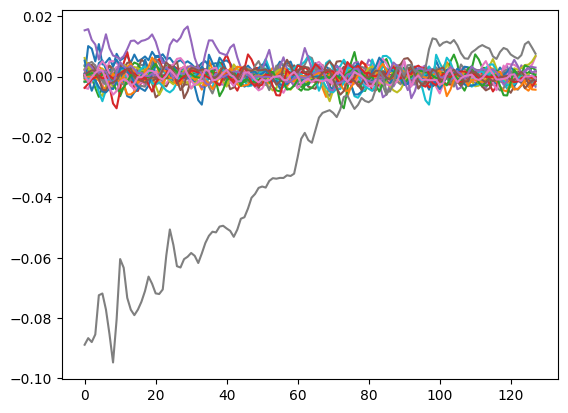

In [182]:
import seaborn as sns

offset = 0
n = 28
plot_data = train_data[0][offset:offset+n].to_numpy()
print("acciones realizadas en el plot: ", np.unique(Y_train[offset:offset+n]))
for row in plot_data:
    sns.lineplot(data=row)

### Procesamiento

In [96]:
# Extraer features usando pyts
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(n_shapelets=1, window_sizes=[1])

new_X_train = []
for df in X_train:
    new_df = st.fit_transform(df, Y_train)
    new_X_train.append(new_df)

new_df = st.fit_transform(X_train[0][:100], Y_train[:100])
new_df.shape

# print(len(new_X_train[0]))
# Normalizar

(100, 1)

## Modelos de Clasificación

### Modelo 1

### Modelo 2

## Training

### Split

In [ ]:
xtrain, xval, ytrain, yval = train_test_split()

### Resultados

## Submission

In [183]:
# Procesar xtest

# Ejecutar modelo


In [177]:
# Exportar csv